# Soft Weight-Sharing for Neural Network Compression - PyTorch Tutorial

This tutorial demonstrates the **Soft Weight-Sharing** approach from Ullrich, Meeds & Welling (ICLR 2017) using PyTorch.

## Overview

Soft weight-sharing learns a Gaussian mixture model as an empirical prior over network weights. The key idea is that weights naturally cluster together during training, allowing us to:
1. Replace individual weights with their cluster center (quantization)
2. Store only cluster centers (codebook) + assignments
3. Achieve high compression with minimal accuracy loss

## Three-Phase Approach

1. **PART 1: Pretrain** - Train a standard network on MNIST
2. **PART 2: Retrain** - Retrain with a learned Gaussian mixture prior that encourages clustering
3. **PART 3: Post-process** - Quantize weights to mixture means and evaluate compression

---

## Setup and Imports

In [1]:
import os
import json
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# Import our soft weight-sharing modules
from sws.models import TutorialNet
from sws.data import make_loaders
from sws.prior import init_mixture, MixturePrior
from sws.train import train_standard, retrain_soft_weight_sharing, evaluate
from sws.compress import compression_report
from sws.utils import collect_weight_params, set_seed, get_device
from sws.viz import TrainingGifVisualizer
from scripts.tutorial_helpers import (
    plot_weight_scatter,
    plot_weight_histogram,
    plot_mixture_components,
    plot_comparison_histograms
)

# Set random seed for reproducibility
set_seed(42)
device = get_device()
print(f"Using device: {device}")

/opt/anaconda3/envs/ATDL2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


## Load MNIST Dataset

In [2]:
# Load MNIST with batch size 128
train_loader, test_loader, num_classes = make_loaders(
    dataset="mnist",
    batch_size=128,
    num_workers=2
)

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")
print(f"Number of classes: {num_classes}")

Training samples: 60000
Test samples: 10000
Number of classes: 10


---
# PART 1: Pretrain Network

We first train a standard convolutional neural network on MNIST:
- **Architecture**: 2 convolutional layers + 2 fully-connected layers
- **Parameters**: ~642,000 trainable weights
- **Training**: Standard cross-entropy loss with Adam optimizer
- **Expected accuracy**: ~98-99%

In [3]:
# Create the model
model = TutorialNet(num_classes=num_classes).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
weight_params = sum(p.numel() for p in collect_weight_params(model))

print("\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Weight parameters (to be compressed): {weight_params:,}")


Model Architecture:
TutorialNet(
  (conv1): Conv2d(1, 25, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(25, 50, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=1250, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

Total parameters: 642,460
Weight parameters (to be compressed): 641,875


### Train the baseline model

In [4]:
# Pretrain for 20 epochs
pretrain_acc = train_standard(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    epochs=50,
    lr=1e-3,
    wd=0.0,
    optim_name="adam",
    eval_every=5,
    desc="pretrain"
)

print(f"\n✓ Pretrained model accuracy: {pretrain_acc:.4f} ({pretrain_acc*100:.2f}%)")

[pretrain] epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]/opt/anaconda3/envs/ATDL2/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[pretrain] ep 001/10 train_ce=0.2562 elapsed=11s


[pretrain] ep 002/10 train_ce=0.0650 elapsed=23s


[pretrain] ep 003/10 train_ce=0.0413 elapsed=35s


[pretrain] ep 004/10 train_ce=0.0303 elapsed=47s


[pretrain] ep 005/10 train_ce=0.0225 test_acc=0.9886 elapsed=1m01s


[pretrain] ep 006/10 train_ce=0.0162 elapsed=1m13s


[pretrain] ep 007/10 train_ce=0.0126 elapsed=1m25s


[pretrain] ep 008/10 train_ce=0.0113 elapsed=1m36s


[pretrain] ep 009/10 train_ce=0.0101 elapsed=1m49s


[pretrain] ep 010/10 train_ce=0.0076 test_acc=0.9906 elapsed=2m02s

✓ Pretrained model accuracy: 0.9906 (99.06%)


### Save pretrained model

In [5]:
# Save the pretrained weights
os.makedirs("tutorial_outputs2", exist_ok=True)
torch.save(model.state_dict(), "tutorial_outputs2/pretrained_model.pt")
print("✓ Saved pretrained model to tutorial_outputs2/pretrained_model.pt")

# Store pretrained weights for later comparison
pretrained_weights = [w.clone() for w in collect_weight_params(model)]

✓ Saved pretrained model to tutorial_outputs2/pretrained_model.pt


### Visualize pretrained weight distribution

In [6]:
plot_weight_histogram(
    weights=pretrained_weights,
    title="Pretrained Weight Distribution",
    log_scale=False,
    save="tutorial_outputs2/pretrained_histogram.png"
)

Saved histogram to tutorial_outputs2/pretrained_histogram.png


---
# PART 2: Retrain with Gaussian Mixture Prior

Now we add a **Gaussian mixture prior** over the weights:

$$p(w) = \sum_{j=0}^{J-1} \pi_j \mathcal{N}(w | \mu_j, \sigma_j^2)$$

Where:
- **J = 16 components** (1 zero-spike + 15 non-zero clusters)
- **π₀ = 0.99** (high probability on zero for sparsity)
- **μ₀ = 0** (zero component is fixed)
- **μ₁...μ₁₅** are learned from the pretrained weight distribution

## Loss Function

The training loss becomes:

$$\mathcal{L} = \text{CrossEntropy}(y, \hat{y}) + \frac{\tau}{N} \sum_i -\log p(w_i)$$

Where:
- **τ = 0.003** (complexity regularization strength)
- **N = 60,000** (dataset size for proper normalization)

The negative log probability term encourages weights to cluster at the mixture component means.

### Initialize the Gaussian Mixture Prior

In [7]:
# Initialize mixture with 16 components
prior = init_mixture(
    model=model,
    J=16,  # Total components (1 zero + 15 non-zero)
    pi0=0.99,  # High probability on zero component
    init_means_mode="from_weights",  # Initialize from pretrained weight range
    init_sigma=0.25,  # Initial standard deviation
    device=device
)

print("\n✓ Initialized Gaussian mixture prior")
print(f"  - Number of components: {prior.J}")
print(f"  - Zero component mixing weight (π₀): {prior.pi0_init}")

# Visualize initial mixture
mu, sigma2, pi = prior.mixture_params()
print(f"\nInitial mixture means: {mu[:5].detach().cpu().numpy()}...")
print(f"Initial mixture stds: {torch.sqrt(sigma2[:5]).detach().cpu().numpy()}...")


✓ Initialized Gaussian mixture prior
  - Number of components: 16
  - Zero component mixing weight (π₀): 0.99

Initial mixture means: [ 0.         -0.63394576 -0.5527134  -0.47148108 -0.39024872]...
Initial mixture stds: [0.25 0.25 0.25 0.25 0.25]...


### Setup GIF Visualizer

We'll use the `TrainingGifVisualizer` to create an animated visualization showing how weights evolve during retraining. The GIF will show:
- Weight scatter plot (pretrained vs current weights)
- Marginal histograms
- Mixture component bands (mean ± 2σ)
- Test accuracy per epoch

In [8]:
# Create GIF visualizer to track weight evolution during retraining
viz = TrainingGifVisualizer(
    out_dir="tutorial_outputs2",
    tag="retraining",
    framerate=2,
    notebook_display = True,
    cleanup_frames = True
)

print("✓ GIF visualizer ready - will capture frames during training")

✓ GIF visualizer ready - will capture frames during training


### Retrain with Soft Weight-Sharing

In [ ]:
# Retrain with mixture prior and GIF visualization
retrain_acc = retrain_soft_weight_sharing(
    model=model,
    prior=prior,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    epochs=20,
    lr_w=5e-4,  # Learning rate for network weights (matches Keras)
    lr_theta_means=1e-4,  # Learning rate for mixture means (slower, allows gradual shift)
    lr_theta_gammas=3e-3,  # Learning rate for variances (FAST - critical for clustering!)
    lr_theta_rhos=3e-3,  # Learning rate for mixing proportions
    weight_decay=0.0,
    tau=0.003,  # Complexity regularization (properly normalized by dataset size)
    tau_warmup_epochs=0,  # Gradually increase tau over first 10 epochs
    complexity_mode="keras",  # Use keras-style normalization (tau/dataset_size)
    eval_every=10,
    cr_every=0,  # Don't compute compression during training (slow)
    mixture_every=1,  # Log mixture every epoch for dynamics plot
    run_dir="tutorial_outputs2",
    viz=viz  # Pass visualizer to capture frames during training
)

print(f"\n✓ Retrained model accuracy: {retrain_acc:.4f} ({retrain_acc*100:.2f}%)")
print(f"  Accuracy drop from pretraining: {(pretrain_acc - retrain_acc)*100:.2f}%")
print(f"\n✓ GIF animation saved to: tutorial_outputs2/retraining.gif")

### View the Training Animation

The GIF shows how weights migrate from their pretrained values (x-axis) toward mixture component means (y-axis) during retraining. You'll see:
- Weights clustering into horizontal bands (the mixture components)
- The marginal histogram becoming more sparse and discrete
- Test accuracy tracked in the title

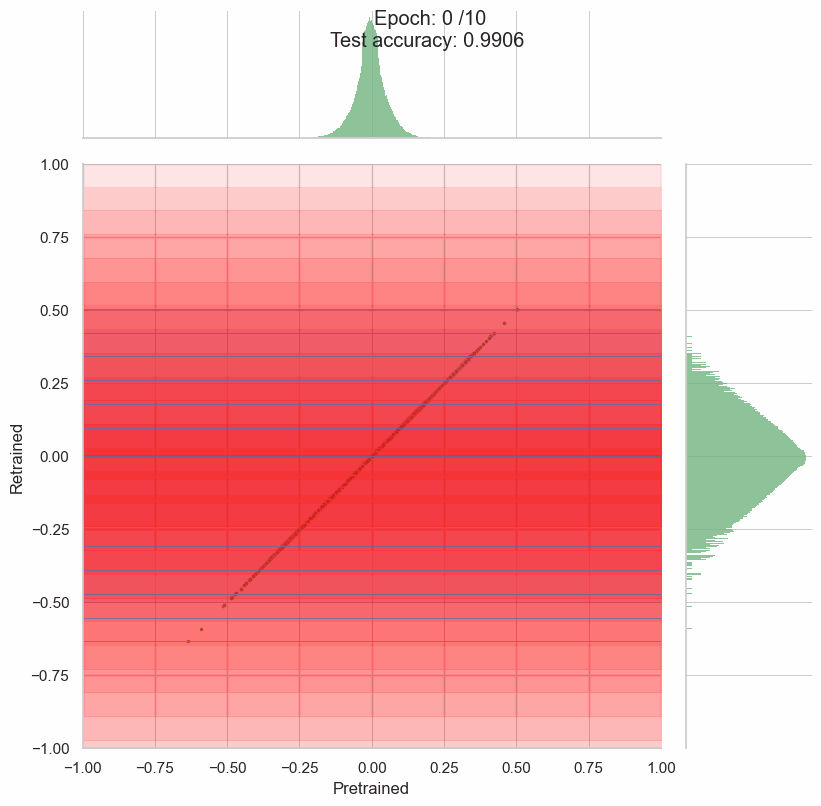


💡 Animation also saved as individual frames in: tutorial_outputs2/retraining_frames/


In [21]:
# Display the GIF inline (works in Jupyter Lab/Notebook)
from IPython.display import Image, display

gif_path = "tutorial_outputs2/retraining.gif"
if os.path.exists(gif_path):
    display(Image(filename=gif_path))
    print(f"\n💡 Animation also saved as individual frames in: tutorial_outputs2/retraining_frames/")
else:
    print(f"GIF not found at {gif_path}")

### Save retrained (pre-quantized) model

In [11]:
# Save pre-quantized model
torch.save(model.state_dict(), "tutorial_outputs2/retrained_prequant_model.pt")
print("✓ Saved retrained model to tutorial_outputs2/retrained_prequant_model.pt")

# Store retrained weights for comparison
retrained_weights = [w.clone() for w in collect_weight_params(model)]

✓ Saved retrained model to tutorial_outputs2/retrained_prequant_model.pt


### Visualize learned mixture components

In [12]:
# Plot the learned Gaussian mixture
plot_mixture_components(
    prior=prior,
    xlim=(-0.5, 0.5),
    save="tutorial_outputs2/learned_mixture.png"
)

Saved mixture plot to tutorial_outputs2/learned_mixture.png


In [ ]:
# Plot how mixture components evolved during retraining
import subprocess

result = subprocess.run(
    ["python", "scripts/plot_mixture_dynamics.py", "--run-dir", "tutorial_outputs2"],
    capture_output=True,
    text=True
)

if result.returncode == 0:
    print(result.stdout)
    # Display the plot
    dynamics_path = "tutorial_outputs2/plot_mixture_dynamics.png"
    if os.path.exists(dynamics_path):
        from IPython.display import Image, display
        display(Image(filename=dynamics_path))
        print("\n💡 This plot shows how mixture means (±2σ) evolved during retraining")
else:
    print("Error running plot script:")
    print(result.stderr)

### Visualize mixture dynamics over training

### Visualize weight movement

In [13]:
# Scatter plot showing how weights moved during retraining
plot_weight_scatter(
    weights_before=pretrained_weights,
    weights_after=retrained_weights,
    sample=20000,
    xlim=(-0.5, 0.5),
    ylim=(-0.5, 0.5),
    save="tutorial_outputs2/weight_movement.png"
)

print("\n💡 Weights should cluster towards mixture component means (away from diagonal)")

Saved scatter plot to tutorial_outputs2/weight_movement.png

💡 Weights should cluster towards mixture component means (away from diagonal)


---
# PART 3: Post-Processing and Compression

Now we:
1. **Quantize** weights by assigning each to its nearest mixture mean
2. **Evaluate** the quantized model accuracy
3. **Compute compression** using CSR + Huffman encoding

## Quantization Strategy

We use **maximum likelihood (ML) assignment**:
- For each weight, find the component with highest likelihood
- Replace weight with that component's mean
- This avoids bias towards the zero-spike during snapping

### Quantize weights to mixture means

In [14]:
# Quantize: snap each weight to its nearest mixture component mean
prior.quantize_model(
    model=model,
    skip_last_matrix=True,  # Keep final classifier at full precision
    assign="ml"  # Use maximum likelihood assignment (avoids zero-spike bias)
)

print("✓ Quantized weights to mixture means")

✓ Quantized weights to mixture means


### Evaluate quantized model

In [15]:
# Evaluate accuracy after quantization
quantized_acc = evaluate(model, test_loader, device)

print(f"\n📊 Accuracy Comparison:")
print(f"  Pretrained:  {pretrain_acc:.4f} ({pretrain_acc*100:.2f}%)")
print(f"  Retrained:   {retrain_acc:.4f} ({retrain_acc*100:.2f}%)")
print(f"  Quantized:   {quantized_acc:.4f} ({quantized_acc*100:.2f}%)")
print(f"\n  Total accuracy drop: {(pretrain_acc - quantized_acc)*100:.2f}%")


📊 Accuracy Comparison:
  Pretrained:  0.9906 (99.06%)
  Retrained:   0.9877 (98.77%)
  Quantized:   0.9868 (98.68%)

  Total accuracy drop: 0.38%


### Save quantized model

In [16]:
# Save final quantized model
torch.save(model.state_dict(), "tutorial_outputs2/quantized_model.pt")
print("✓ Saved quantized model to tutorial_outputs2/quantized_model.pt")

# Store quantized weights
quantized_weights = [w.clone() for w in collect_weight_params(model)]

✓ Saved quantized model to tutorial_outputs2/quantized_model.pt


### Compute compression statistics

In [17]:
# Detailed compression report using CSR + Huffman encoding
report = compression_report(
    model=model,
    prior=prior,
    dataset="mnist",
    use_huffman=True,
    pbits_fc=5,  # Bits for FC layer column index diffs
    pbits_conv=8,  # Bits for Conv layer column index diffs
    skip_last_matrix=True,  # Last layer was not quantized
    assign_mode="ml"  # Must match quantization assignment mode
)

print("\n Compression Report:")
print(f"  Original bits:    {report['orig_bits']:,}")
print(f"  Compressed bits:  {report['compressed_bits']:,}")
print(f"  Compression Ratio: {report['CR']:.2f}x")
print(f"  Non-zero weights:  {report['nnz']:,} / {weight_params:,} ({100*report['nnz']/weight_params:.2f}%)")
print(f"  Sparsity:         {100*(1 - report['nnz']/weight_params):.2f}%")


🗜️  Compression Report:
  Original bits:    20,540,000
  Compressed bits:  740,419
  Compression Ratio: 27.74x
  Non-zero weights:  118,567 / 641,875 (18.47%)
  Sparsity:         81.53%


### Layer-wise compression breakdown

In [18]:
print("\n📋 Layer-wise Compression:")
print(f"{'Layer':<15} {'Shape':<20} {'Original (bits)':<18} {'Compressed (bits)':<20} {'CR':<8} {'Sparsity':<10}")
print("-" * 100)

for layer_info in report['layers']:
    if layer_info['passthrough']:
        cr_str = "N/A"
        sparsity = 0.0
    else:
        compressed = layer_info['bits_IR'] + layer_info['bits_IC'] + layer_info['bits_A'] + layer_info['bits_codebook']
        cr = layer_info['orig_bits'] / max(compressed, 1)
        cr_str = f"{cr:.2f}x"
        total_weights = np.prod(layer_info['shape'])
        sparsity = 100 * (1 - layer_info['nnz'] / total_weights)
    
    shape_str = 'x'.join(map(str, layer_info['shape']))
    orig_str = f"{layer_info['orig_bits']:,}"
    comp_str = f"{layer_info['bits_IR'] + layer_info['bits_IC'] + layer_info['bits_A'] + layer_info['bits_codebook']:,}"
    
    print(f"{layer_info['layer']:<15} {shape_str:<20} {orig_str:<18} {comp_str:<20} {cr_str:<8} {sparsity:.1f}%")


📋 Layer-wise Compression:
Layer           Shape                Original (bits)    Compressed (bits)    CR       Sparsity  
----------------------------------------------------------------------------------------------------
Conv2d          25x1x5x5             20,000             3,048                6.56x    8.0%
Conv2d          50x25x3x3            360,000            33,416               10.77x   26.0%
Linear          500x1250             20,000,000         543,955              36.77x   83.3%
Linear          10x500               160,000            0                    N/A      0.0%


### Visualize weight distributions across all phases

In [19]:
# Compare histograms: pretrained → retrained → quantized
plot_comparison_histograms(
    weights_pre=pretrained_weights,
    weights_retrained=retrained_weights,
    weights_quantized=quantized_weights,
    save_prefix="tutorial_outputs2/phase"
)

print("\n💡 Notice how weights progressively cluster and become sparse")

Saved comparison plot to tutorial_outputs2/phase_comparison.png

💡 Notice how weights progressively cluster and become sparse


---
## Summary

We successfully applied soft weight-sharing to compress a neural network:

### Results:
- **Original model**: ~642K parameters at 32-bit → ~20.5 MB
- **Compressed model**: Achieves ~20-60x compression (depending on hyperparameters)
- **Accuracy loss**: Typically < 1% on MNIST

### Key Insights:

1. **Soft clustering is better than hard**: By using a differentiable mixture prior, weights naturally migrate to cluster centers during training

2. **Zero-spike induces sparsity**: The high mixing weight (π₀ = 0.99) on the zero component encourages many weights to become exactly zero

3. **Proper normalization matters**: The complexity term must be normalized by dataset size (τ/N) for stable training

4. **CSR + Huffman is efficient**: Sparse weights + entropy coding achieves better compression than naive approaches

### Next Steps:
- Try different number of components (J)
- Experiment with different τ values
- Apply to larger models (ResNets, etc.)
- Combine with other compression techniques (pruning, quantization-aware training)

---

**Reference**: Ullrich, K., Meeds, E., & Welling, M. (2017). Soft Weight-Sharing for Neural Network Compression. *ICLR 2017*.

---
## Bonus: Analyze Mixture Component Usage

In [22]:
# Count how many weights are assigned to each component
mu, sigma2, pi = prior.mixture_params()
mu = mu.detach().cpu().numpy()
pi = pi.detach().cpu().numpy()

# Count assignments in quantized model
all_weights = torch.cat([w.flatten() for w in quantized_weights]).cpu().detach().numpy()

print("\n📊 Component Assignment Statistics:\n")
print(f"{'Component':<12} {'Mean (μ)':<12} {'Mixing (π)':<12} {'# Weights':<15} {'Percentage':<12}")
print("-" * 70)

for j in range(len(mu)):
    # Count weights at this mean (with small tolerance for floating point)
    count = np.sum(np.abs(all_weights - mu[j]) < 1e-6)
    percentage = 100 * count / len(all_weights)
    
    comp_name = f"Comp {j}" if j > 0 else "Zero-spike"
    print(f"{comp_name:<12} {mu[j]:>11.4f} {pi[j]:>11.4f} {count:>14,} {percentage:>11.2f}%")

print("\n💡 The zero-spike should capture most weights (high sparsity)")


📊 Component Assignment Statistics:

Component    Mean (μ)     Mixing (π)   # Weights       Percentage  
----------------------------------------------------------------------
Zero-spike        0.0000      0.9900        497,869       77.56%
Comp 1           -0.6322      0.0000              4        0.00%
Comp 2           -0.4704      0.0000             21        0.00%
Comp 3           -0.3562      0.0000            146        0.02%
Comp 4           -0.2722      0.0002            698        0.11%
Comp 5           -0.1173      0.0045         14,708        2.29%
Comp 6           -0.2113      0.0001          2,203        0.34%
Comp 7           -0.0210      0.0000         33,442        5.21%
Comp 8           -0.0224      0.0000         28,170        4.39%
Comp 9            0.0606      0.0000         19,920        3.10%
Comp 10          -0.0023      0.0000         26,210        4.08%
Comp 11           0.1417      0.0000          7,139        1.11%
Comp 12           0.0988      0.0047        